In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import time

In [243]:
def succ_prob_calc(B_orig, logicals_in, s_nodes, loss_inds):
    ######################################################
    ## inputs:
    ## B_orig [type: networkx]: stabilizer graph, two kinds of nodes: qubit 1...N and stabilizer s1...s_{Ns}
    ## logicals_in [type: list of numpy arrays]: logical operators in every row, columns act on qubits
    ## s_nodes [type: list]: list of stabilizer nodes s1...s_{Ns}
    ## loss_inds [type: numpy array]: index of erased qubits
    #####################
    ## output:
    ## succ_fail [type: binary value]: 0 (failure), 1(success)
    ######################################################
    B = B_orig.copy()
    logicals = list(np.copy(logicals_in))
    s_nodes_set = set(np.copy(s_nodes))

    Ns_remain = len(s_nodes_set) # number of stabilizer generators
    q_remain = list(set(B.nodes())-s_nodes_set) # number of qubits (anciall+data)
    node_list = list(s_nodes_set) + q_remain  # indices of all nodes in graph
    adj_mat_new = nx.to_numpy_array(B, nodelist = node_list) # adjaceny matrix of stabilizer graph
    Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:] # stabilizer group matrix

    for i_q, q in enumerate(loss_inds):
        ## correct logical operators
        # if Ns_remain> 0:
        #     logicals = correct_logical(q,logicals, Sx_mat)
        # logicals = correct_logical(logicals, Sx_mat, q+Nq)
        if len(logicals) == 1:
        #     if logicals[0][q]>0:
        #         if Ns_remain> 0:
        #             st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
        #             if len(st_ind)>0:
        #                 logicals[0] = (logicals[0]+Sx_mat[st_ind[0],:]) % 2
        #         else:
            logicals.pop()
        else:
            for i_log in np.arange(len(logicals)-1,-1,-1):
                if logicals[i_log][q]>0:
                    if Ns_remain> 0:
                        st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                        if len(st_ind)>0:
                            logicals[i_log] = (logicals[i_log]+Sx_mat[st_ind[0],:]) % 2
                    else:
                        logicals.pop(i_log)            
        ## update stabilizer group
        ## first: update graph
        if q in B:
            B, s_nodes_set = modify_graph(q,B,s_nodes_set)
        ## second: update stabilizer group matrix
            Ns_remain = len(s_nodes_set)
            if Ns_remain> 0:
                q_remain = list(set(B.nodes())-s_nodes_set)
                node_list = list(s_nodes_set) + q_remain
                adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
                Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
                Sx_mat = np.zeros((Ns_remain,N))
                Sx_mat[:,q_remain] = Sx_red
            else:
                Sx_mat = []
                # break
        
        # logicals = correct_logical(logicals, Sx_mat, q+Nq)
        # q2 = q+Nq
        # if q2 in B:
        #     B, s_nodes_set = modify_graph(q2,B,s_nodes_set)
        # ## second: update stabilizer group matrix
        #     Ns_remain = len(s_nodes_set)
        #     if Ns_remain> 0:
        #         q_remain = list(set(B.nodes())-s_nodes_set)
        #         node_list = list(s_nodes_set) + q_remain
        #         adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
        #         Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
        #         Sx_mat = np.zeros((Ns_remain,N))
        #         Sx_mat[:,q_remain] = Sx_red
        #     else:
        #         Sx_mat = []
        #         break

    succ_fail = 0 # default value: failure
    # if Ns_remain > 0:
    #     return int(len(logicals)/2)
    # elif i_q == len(loss_inds)-1:
    #     return int(len(logicals)/2)
    if len(logicals)==2:
        if np.sum(logicals[0][loss_inds]+logicals[1][loss_inds])==0:
            # print(logicals)
            return 1
        else:
            return 0
    else:
        return 0
    
def modify_graph(q,B,s_nodes_set):
    sq = [n for n in B.neighbors(q)]
    if len(sq)==1:
        B.remove_nodes_from(sq)
        s_nodes_set -= set(sq)
    elif len(sq)>1:
        double_edgs = []
        for i in range(len(sq)-1):
            n0 = set(B.neighbors(sq[i]))
            n1 = set(B.neighbors(sq[i+1]))
            rep_qs = n0.intersection(n1)
            q0 = list(set(n0)-rep_qs)
            q1 = list(set(n1)-rep_qs)
            double_edgs += [(sq[i], e) for e in q0]
            double_edgs += [(sq[i], e) for e in q1]
        G = nx.Graph()
        G.add_nodes_from(sq[:-1])
        G.add_edges_from(double_edgs)
        sq_remain = list(s_nodes_set-set(sq))
        for s in sq_remain:
            G.add_edges_from([(s, e) for e in B.neighbors(s)])
        B = G
        s_nodes_set -= {sq[-1]}
    return B, s_nodes_set


def correct_logical(q,logicals_in, Sx_mat):
    logicals = list(np.copy(logicals_in))
    if len(logicals) == 1:
        if logicals[0][q]>0:            
            st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
            if len(st_ind)>0:
                logicals[0] = (logicals[0]+Sx_mat[st_ind[0],:]) % 2
            else:
                logicals.pop()

    else:
        for i_log in np.arange(len(logicals)-1,-1,-1):
            if logicals[i_log][q]>0:            
                st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                if len(st_ind)>0:
                    logicals[i_log] = (logicals[i_log]+Sx_mat[st_ind[0],:]) % 2
                else:
                    logicals.pop(i_log)
    return logicals

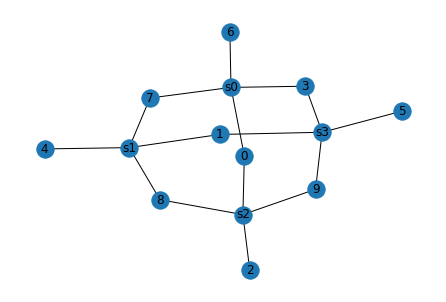

In [203]:
## with logical operator
Sx = np.array([[1,0,0,1,0],\
               [0,1,0,0,1],\
               [1,0,1,0,0],\
               [0,1,0,1,0]])

Sz = np.array([[0,1,1,0,0],\
               [0,0,1,1,0],\
               [0,0,0,1,1],\
               [1,0,0,0,1]])
S_mat = np.concatenate((Sx,Sz),axis=1)
N = np.size(S_mat,1) # 2xnumber of data qubits 
Ns = np.size(S_mat,0) # number of stabilizers 
Nq = int(N/2) # number of data qubits

## construct stabilizer graph
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)
for row in range(Ns):
    qs = np.argwhere(S_mat[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

nx.draw(B_orig,  with_labels=True)
plt.show()
logical = np.kron(np.eye(2),np.ones((1,Nq)))

p_list = np.linspace(0.01,0.99,20)
Nrep = 2000 # number of MC iterations
succ_prob = np.zeros(len(p_list))

for i_p, p in enumerate(p_list):
    for i_rep in range(Nrep):
        lost_q_inds = np.random.permutation(np.argwhere(np.random.rand(Nq)<p)[:,0])
        loss_inds = np.concatenate((lost_q_inds,Nq+lost_q_inds))
        succ_prob[i_p] += succ_prob_calc(B_orig, logical, s_nodes, loss_inds)
            
succ_prob /= Nrep

In [40]:
print(S_mat)

[[1 0 0 1 0 0 1 1 0 0]
 [0 1 0 0 1 0 0 1 1 0]
 [1 0 1 0 0 0 0 0 1 1]
 [0 1 0 1 0 1 0 0 0 1]]


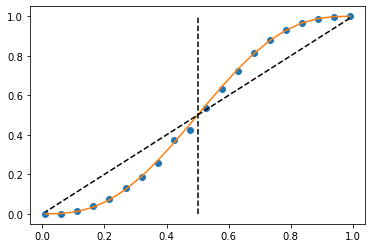

In [233]:
plt.plot(1-p_list,succ_prob,"o")
f = lambda x: x**5 + 5* x**4* (1-x) + 5*2*x**3 * (1-x)**2 #+ 5*2*x**2 * (1-x)**3 + 5*x * (1-x)**4 
plt.plot(1-p_list,f(1-p_list),"-")
plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-1/2
plt.plot([x0,x0],[0,1],"k--")
plt.show()

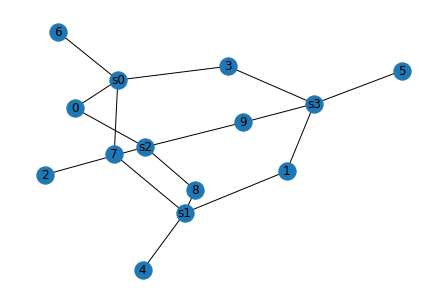

[ 0.  5. 10.  0.  0.  0.]


In [261]:
## with logical operator
Sx = np.array([[1,0,0,1,0],\
               [0,1,0,0,1],\
               [1,0,1,0,0],\
               [0,1,0,1,0]])

Sz = np.array([[0,1,1,0,0],\
               [0,0,1,1,0],\
               [0,0,0,1,1],\
               [1,0,0,0,1]])
S_mat = np.concatenate((Sx,Sz),axis=1)
N = np.size(S_mat,1) # 2xnumber of data qubits 
Ns = np.size(S_mat,0) # number of stabilizers 
Nq = int(N/2) # number of data qubits

## construct stabilizer graph
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)
for row in range(Ns):
    qs = np.argwhere(S_mat[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

nx.draw(B_orig,  with_labels=True)
plt.show()
logical = np.kron(np.eye(2),np.ones((1,Nq)))

config_num_5 = np.zeros(Nq+1)
q_list = np.arange(Nq)

for Nq_loss in np.arange(1,Nq+1):
    for loss_pattern in findsubsets(q_list,Nq_loss):
        # print(loss_pattern)
        loss_inds = np.concatenate((np.array(list(loss_pattern)),Nq+np.array(list(loss_pattern)).astype(int)))
        # print(loss_inds)
        config_num_5[Nq_loss] += succ_prob_calc(B_orig, logical, s_nodes, loss_inds)
print(config_num_5)

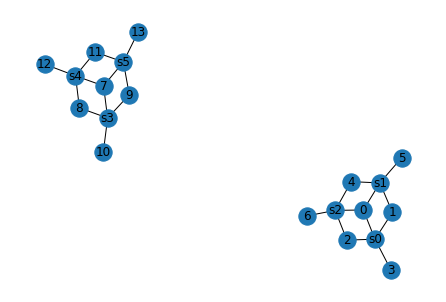

In [196]:
## with logical operator
Sx_mat = np.array([[1,1,1,1,0,0,0],\
            [1,1,0,0,1,1,0],\
            [1,0,1,0,1,0,1]])

S_mat = np.kron(np.eye(2),Sx_mat)
N = np.size(S_mat,1) # 2xnumber of data qubits 
Ns = np.size(S_mat,0) # number of stabilizers 
Nq = int(N/2) # number of data qubits

## construct stabilizer graph
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)
for row in range(Ns):
    qs = np.argwhere(S_mat[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

nx.draw(B_orig,  with_labels=True)
plt.show()
logical = np.kron(np.eye(2),np.ones((1,Nq)))

p_list = np.linspace(0.01,0.99,20)
Nrep = 2000 # number of MC iterations
succ_prob_7 = np.zeros(len(p_list))

for i_p, p in enumerate(p_list):
    for i_rep in range(Nrep):
        lost_q_inds = np.random.permutation(np.argwhere(np.random.rand(Nq)<p)[:,0])
        loss_inds = np.concatenate((lost_q_inds,Nq+lost_q_inds))
        succ_prob_7[i_p] += succ_prob_calc(B_orig, logical, s_nodes, loss_inds)
            
succ_prob_7 /= Nrep

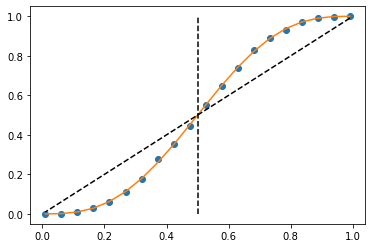

In [262]:
plt.plot(1-p_list,succ_prob_7,"o")
# f = lambda x: x**7 + 7*x**6*(1-x) + 7*3*x**5 * (1-x)**2 + 7*5 *x**4 * (1-x)**3 
f = lambda x: x**7 + 7*x**6*(1-x) + 7*3*x**5 * (1-x)**2 + 28 *x**4 * (1-x)**3 + 7*x**3 * (1-x)**4 
plt.plot(1-p_list,f(1-p_list),"-")
plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-1/2
plt.plot([x0,x0],[0,1],"k--")
plt.show()

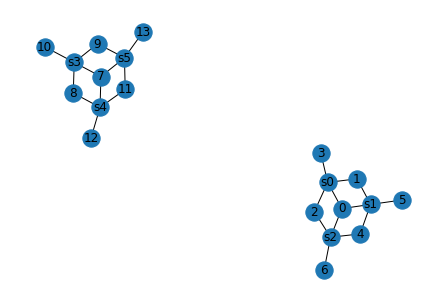

[ 0.  7. 21. 28.  7.  0.  0.  0.]


In [260]:
## with logical operator
Sx_mat = np.array([[1,1,1,1,0,0,0],\
            [1,1,0,0,1,1,0],\
            [1,0,1,0,1,0,1]])

S_mat = np.kron(np.eye(2),Sx_mat)
N = np.size(S_mat,1) # 2xnumber of data qubits 
Ns = np.size(S_mat,0) # number of stabilizers 
Nq = int(N/2) # number of data qubits

## construct stabilizer graph
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)
for row in range(Ns):
    qs = np.argwhere(S_mat[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

nx.draw(B_orig,  with_labels=True)
plt.show()
logical = np.kron(np.eye(2),np.ones((1,Nq)))

config_num_7 = np.zeros(Nq+1)
q_list = np.arange(Nq)

for Nq_loss in np.arange(1,Nq+1):
    for loss_pattern in findsubsets(q_list,Nq_loss):
        # print(loss_pattern)
        loss_inds = np.concatenate((np.array(list(loss_pattern)),Nq+np.array(list(loss_pattern)).astype(int)))
        # print(loss_inds)
        config_num_7[Nq_loss] += succ_prob_calc(B_orig, logical, s_nodes, loss_inds)

print(config_num_7)

In [223]:
import itertools
def findsubsets(s, n):
    return list(itertools.combinations(s, n))

x = np.arange(Nq)
for loss_pattern in findsubsets(x,3):
    print(list(loss_pattern))

[0, 1, 2]
[0, 1, 3]
[0, 1, 4]
[0, 2, 3]
[0, 2, 4]
[0, 3, 4]
[1, 2, 3]
[1, 2, 4]
[1, 3, 4]
[2, 3, 4]


## sanity check

stabilizer ops. are
[[1 0 0 1 0 0 1 1 0 0]
 [0 1 0 0 1 0 0 1 1 0]
 [1 0 1 0 0 0 0 0 1 1]
 [0 1 0 1 0 1 0 0 0 1]]


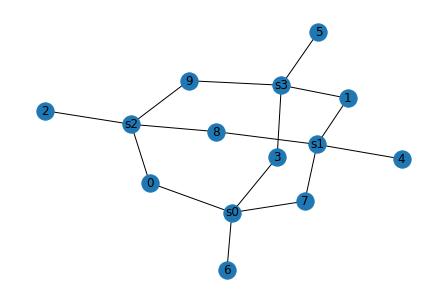

list of erased qubits: [1 2 4 6 7 9]
-------------------------
erased qubit: 1
log op. is  [array([1., 0., 1., 1., 0., 0., 0., 1., 1., 0.]), array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])]
stabilizer ops. are
[[1. 0. 0. 1. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 1. 1.]]


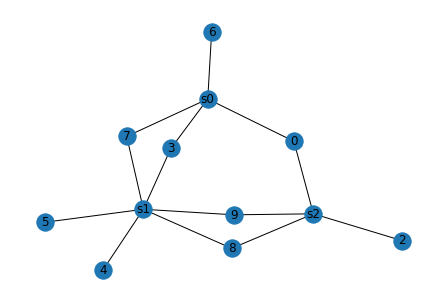

-------------------------
erased qubit: 2
log op. is  [array([0., 0., 0., 1., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])]
stabilizer ops. are
[[1. 0. 0. 1. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 1. 1. 1.]]


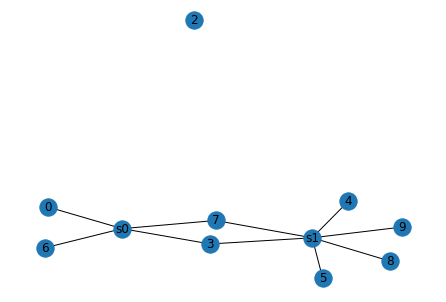

-------------------------
erased qubit: 4
log op. is  [array([0., 0., 0., 1., 0., 0., 0., 1., 0., 1.]), array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])]
stabilizer ops. are
[[1. 0. 0. 1. 0. 0. 1. 1. 0. 0.]]


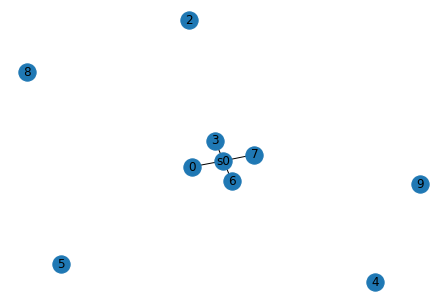

-------------------------
erased qubit: 6
log op. is  [array([0., 0., 0., 1., 0., 0., 0., 1., 0., 1.]), array([1., 0., 0., 1., 0., 1., 0., 0., 1., 1.])]
stabilizer ops. are
[]


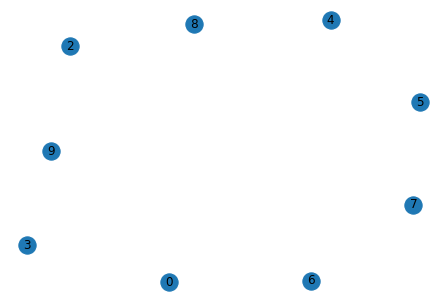

-------------------------
erased qubit: 7
log op. is  [array([1., 0., 0., 1., 0., 1., 0., 0., 1., 1.])]
stabilizer ops. are
[]


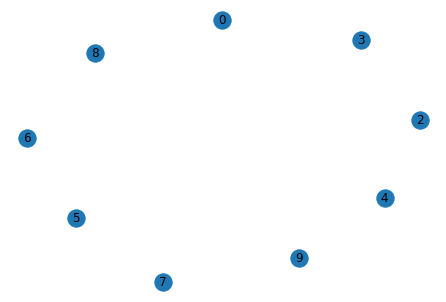

-------------------------
erased qubit: 9
log op. is  []
stabilizer ops. are
[]


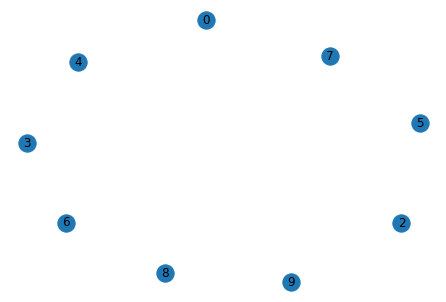

-------------------------
failure


In [237]:
## 5-qubit stabilizer matrix
## with logical operator
Sx = np.array([[1,0,0,1,0],\
               [0,1,0,0,1],\
               [1,0,1,0,0],\
               [0,1,0,1,0]])

Sz = np.array([[0,1,1,0,0],\
               [0,0,1,1,0],\
               [0,0,0,1,1],\
               [1,0,0,0,1]])
S_mat = np.concatenate((Sx,Sz),axis=1)

print("stabilizer ops. are")
print(S_mat)

N = np.size(S_mat,1) # 2xnumber of data qubits 
Ns = np.size(S_mat,0) # number of stabilizers 
Nq = int(N/2) # number of data qubits

## construct stabilizer graph
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)
for row in range(Ns):
    qs = np.argwhere(S_mat[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

nx.draw(B_orig,  with_labels=True)
plt.show()
## logical operator
logicals_in = np.kron(np.eye(2),np.ones((1,Nq)))

p = 0.3 # loss probability
## generate an instance of loss events
lost_q_inds = np.array([1,2,4]) #np.random.permutation(np.argwhere(np.random.rand(Nq)<p)[:,0])
loss_inds = np.concatenate((lost_q_inds,Nq+lost_q_inds))
print("list of erased qubits:", loss_inds)
print("-------------------------")

B = B_orig.copy()
logicals = list(np.copy(logicals_in))
s_nodes_set = set(np.copy(s_nodes))

Ns_remain = len(s_nodes_set) # number of stabilizer generators
q_remain = list(set(B.nodes())-s_nodes_set) # number of qubits (anciall+data)
node_list = list(s_nodes_set) + q_remain  # indices of all nodes in graph
adj_mat_new = nx.to_numpy_array(B, nodelist = node_list) # adjaceny matrix of stabilizer graph
Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:] # stabilizer group matrix

for i_q, q in enumerate(loss_inds):
    print("erased qubit:", q)
    ## correct logical operators
    if len(logicals) == 1:
    #     if logicals[0][q]>0:
    #         if Ns_remain> 0:
    #             st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
    #             if len(st_ind)>0:
    #                 logicals[0] = (logicals[0]+Sx_mat[st_ind[0],:]) % 2
    #         else:
        logicals.pop()
    else:
        for i_log in np.arange(len(logicals)-1,-1,-1):
            if logicals[i_log][q]>0:
                if Ns_remain> 0:
                    st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                    if len(st_ind)>0:
                        logicals[i_log] = (logicals[i_log]+Sx_mat[st_ind[0],:]) % 2
                else:
                    logicals.pop(i_log)    
    print("log op. is ", logicals)
    ## update stabilizer group
    ## first: update graph
    if q in B:
        sq = [n for n in B.neighbors(q)]
        if len(sq)==1:
            B.remove_nodes_from(sq)
            s_nodes_set -= set(sq)
        elif len(sq)>1:
            double_edgs = []
            for i in range(len(sq)-1):
                n0 = set(B.neighbors(sq[i]))
                n1 = set(B.neighbors(sq[i+1]))
                rep_qs = n0.intersection(n1)
                q0 = list(set(n0)-rep_qs)
                q1 = list(set(n1)-rep_qs)
                double_edgs += [(sq[i], e) for e in q0]
                double_edgs += [(sq[i], e) for e in q1]
            G = nx.Graph()
            G.add_nodes_from(sq[:-1])
            G.add_edges_from(double_edgs)
            sq_remain = list(s_nodes_set-set(sq))
            for s in sq_remain:
                G.add_edges_from([(s, e) for e in B.neighbors(s)])
            B = G
            s_nodes_set -= {sq[-1]}

    ## second: update stabilizer group matrix
        Ns_remain = len(s_nodes_set)
        if Ns_remain> 0:
            q_remain = list(set(B.nodes())-s_nodes_set)
            node_list = list(s_nodes_set) + q_remain
            adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
            Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
            Sx_mat = np.zeros((Ns_remain,N))
            Sx_mat[:,q_remain] = Sx_red
        else:
            Sx_mat = []
            # break

        print("stabilizer ops. are")
        print(Sx_mat)
            # print(s_nodes_set,q_remain)

    nx.draw(B,  with_labels=True)
    plt.show()
    print("-------------------------")
    
if len(logicals)==2:
    print("success 1")
    print(np.sum(logicals[0][loss_inds]+logicals[1][loss_inds]))
else:
    print("failure")

stabilizer ops. are
[[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]]


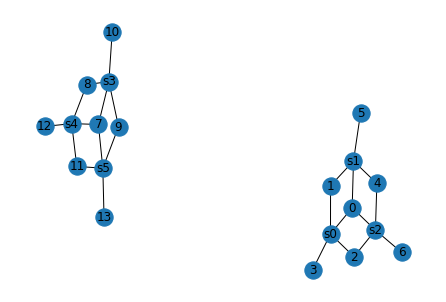

list of erased qubits: [ 1  3  5  6  8 10 12 13]
-------------------------
erased qubit: 1
s0 is applied to log op. 0
log op. is  [array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.])]
stabilizer ops. are
[[0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]]


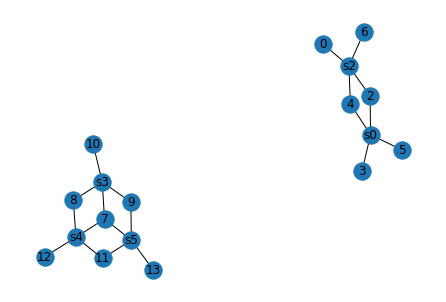

-------------------------
erased qubit: 3
log op. is  [array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.])]
stabilizer ops. are
[[0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]]


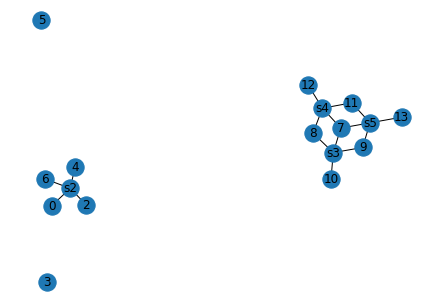

-------------------------
erased qubit: 5
log op. is  [array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.])]
stabilizer ops. are
[[0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]]


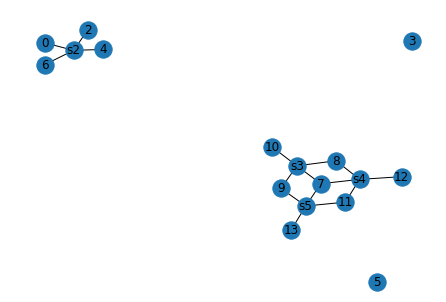

-------------------------
erased qubit: 6
log op. is  [array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.])]
stabilizer ops. are
[[0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]]


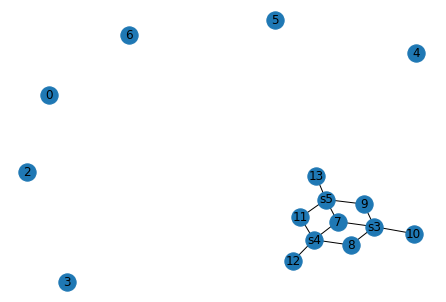

-------------------------
erased qubit: 8
s0 is applied to log op.
log op. is  [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.])]
stabilizer ops. are
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]]


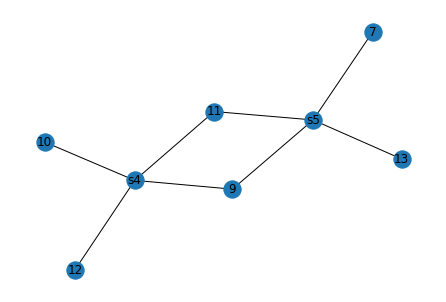

-------------------------
erased qubit: 10
s0 is applied to log op.
log op. is  [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])]
stabilizer ops. are
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]]


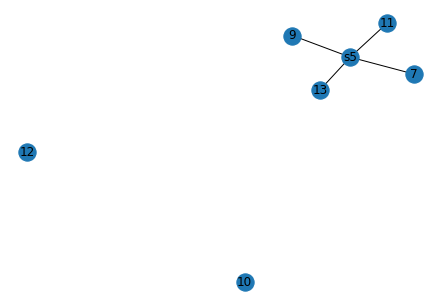

-------------------------
erased qubit: 12
log op. is  []
stabilizer ops. are
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]]


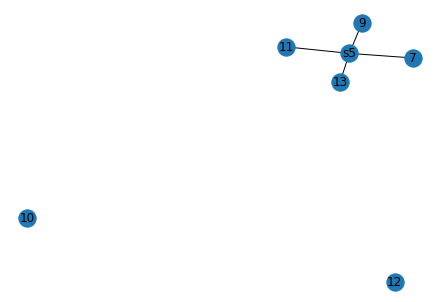

-------------------------
erased qubit: 13
log op. is  []
failure


In [202]:
## 7-qubit stabilizer matrix
## with logical operator
Sx_mat = np.array([[1,1,1,1,0,0,0],\
            [1,1,0,0,1,1,0],\
            [1,0,1,0,1,0,1]])

S_mat = np.kron(np.eye(2),Sx_mat)

print("stabilizer ops. are")
print(S_mat)

N = np.size(S_mat,1) # 2xnumber of data qubits 
Ns = np.size(S_mat,0) # number of stabilizers 
Nq = int(N/2) # number of data qubits

## construct stabilizer graph
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)
for row in range(Ns):
    qs = np.argwhere(S_mat[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

nx.draw(B_orig,  with_labels=True)
plt.show()
## logical operator
logicals_in = np.kron(np.eye(2),np.ones((1,Nq)))


p = 0.3 # loss probability
## generate an instance of loss events
lost_q_inds = np.array([1,3,5,6]) #np.random.permutation(np.argwhere(np.random.rand(Nq)<p)[:,0])
# lost_q_inds = np.random.choice(np.arange(Nq),size=3,replace=False)
loss_inds = np.concatenate((lost_q_inds,Nq+lost_q_inds))
print("list of erased qubits:", loss_inds)
print("-------------------------")

B = B_orig.copy()
logicals = list(np.copy(logicals_in))
s_nodes_set = set(np.copy(s_nodes))

Ns_remain = len(s_nodes_set) # number of stabilizer generators
q_remain = list(set(B.nodes())-s_nodes_set) # number of qubits (anciall+data)
node_list = list(s_nodes_set) + q_remain  # indices of all nodes in graph
adj_mat_new = nx.to_numpy_array(B, nodelist = node_list) # adjaceny matrix of stabilizer graph
Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:] # stabilizer group matrix

for i_q, q in enumerate(loss_inds):
    print("erased qubit:", q)
    ## correct logical operators
    if len(logicals) == 1:
        if logicals[0][q]>0:            
            st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
            if len(st_ind)>0:
                print("s%d is applied to log op." % st_ind[0])
                logicals[0] = (logicals[0]+Sx_mat[st_ind[0],:]) % 2
            else:
                logicals.pop()
    else:
        for i_log in np.arange(len(logicals)-1,-1,-1):
            if logicals[i_log][q]>0:            
                st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                if len(st_ind)>0:
                    print("s%d is applied to log op. %d" % (st_ind[0],i_log))
                    logicals[i_log] = (logicals[i_log]+Sx_mat[st_ind[0],:]) % 2
                else:
                    logicals.pop(i_log)
    print("log op. is ", logicals)

    ## update stabilizer group
    ## first: update graph
    if q in B:
        sq = [n for n in B.neighbors(q)]
        if len(sq)==1:
            B.remove_nodes_from(sq)
            s_nodes_set -= set(sq)
        elif len(sq)>1:
            double_edgs = []
            for i in range(len(sq)-1):
                n0 = set(B.neighbors(sq[i]))
                n1 = set(B.neighbors(sq[i+1]))
                rep_qs = n0.intersection(n1)
                q0 = list(set(n0)-rep_qs)
                q1 = list(set(n1)-rep_qs)
                double_edgs += [(sq[i], e) for e in q0]
                double_edgs += [(sq[i], e) for e in q1]
            G = nx.Graph()
            G.add_nodes_from(sq[:-1])
            G.add_edges_from(double_edgs)
            sq_remain = list(s_nodes_set-set(sq))
            for s in sq_remain:
                G.add_edges_from([(s, e) for e in B.neighbors(s)])
            B = G
            s_nodes_set -= {sq[-1]}

    ## second: update stabilizer group matrix
        Ns_remain = len(s_nodes_set)
        if Ns_remain> 0:
            q_remain = list(set(B.nodes())-s_nodes_set)
            node_list = list(s_nodes_set) + q_remain
            adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
            Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
            Sx_mat = np.zeros((Ns_remain,N))
            Sx_mat[:,q_remain] = Sx_red
        else:
            Sx_mat = []
            break

        print("stabilizer ops. are")
        print(Sx_mat)
            # print(s_nodes_set,q_remain)

    nx.draw(B,  with_labels=True)
    plt.show()
    print("-------------------------")
    
# if Ns_remain > 0:
#     print("success 1")
#     print(np.sum(logicals[0][loss_inds]+logicals[1][loss_inds]))
# elif i_q == len(loss_inds)-1:
#     print("success 2")
#     print(np.sum(logicals[0][loss_inds]+logicals[1][loss_inds]))
    
if len(logicals)==2:
    print("success 1")
    print(np.sum(logicals[0][loss_inds]+logicals[1][loss_inds]))
else:
    print("failure")

In [158]:
logicals[0]

array([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])